In [56]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

In [57]:
class Person(Agent):
    def __init__(self, id, model):
        super().__init__(id,model)
        self.wealth = 1
    
    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

In [58]:
class MoneyModel(Model):
    def __init__(self, number_of_agents = 1):
        self.schedule = RandomActivation(self)
        
        for i in range(number_of_agents):
            agent = Person(i, self)
            self.schedule.add(agent)

    def step(self):
        self.schedule.step()

In [59]:
MAX_ITERATIONS = 10
NUM_AGENTS = 10
model = MoneyModel(NUM_AGENTS)

for i in range(MAX_ITERATIONS):
    model.step()

(array([5., 0., 3., 0., 0., 0., 0., 1., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

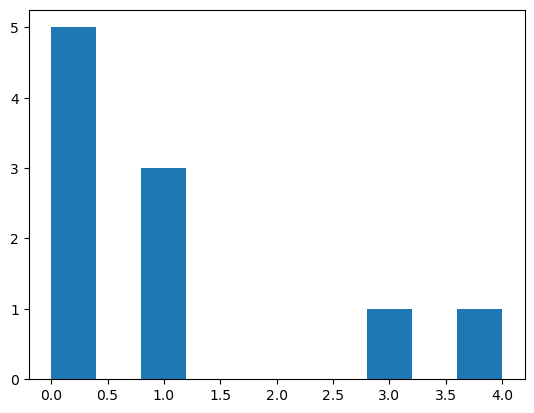

In [60]:
agent_wealth = [agent.wealth for agent in model.schedule.agents]
plt.hist(agent_wealth)

(array([34., 45.,  9., 11.,  1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

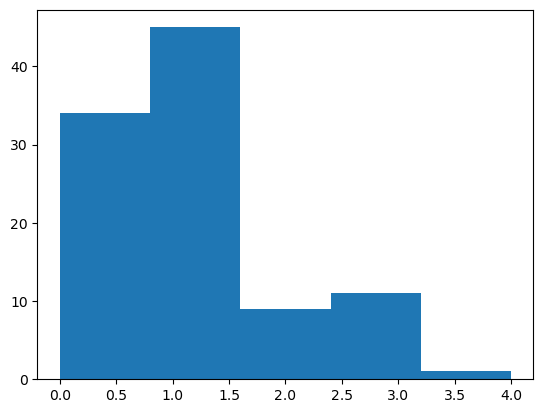

In [61]:
MAX_ITERATIONS = 10
NUM_AGENTS = 10
model = MoneyModel(NUM_AGENTS)

all_wealth = []
for i in range(MAX_ITERATIONS):
    model.step()
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=(max(all_wealth) + 1))

In [62]:
class Person(Agent):
    def __init__(self, id, model):
        super().__init__(id,model)
        self.wealth = 1
    
    def move(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=True)
        new_position = self.random.choice(possible_positions)
        self.model.grid.move_agent(self, new_position)
    
    def give_money(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True)
        if len(neighbors) >= 1:
            other_agent = self.random.choice(neighbors)
            other_agent.wealth += 1
            self.wealth -= 1
    
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [63]:
class MoneyModel(Model):
    def __init__(self, width, height, number_of_agents):
        
        # non-toroidal grid
        self.grid = MultiGrid(width, height, False)
        
        self.schedule = RandomActivation(self)
        
        #self.datacollector =  DataCollector(model_reporters = {"Grid" : get_grid})
        
        for i in range(number_of_agents):
            agent = Person(i, self)
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            self.grid.place_agent(agent, (x,y))
            self.schedule.add(agent)

    def step(self):
        #self.datacollector.collect(self)
        self.schedule.step()

In [64]:
MAX_ITERATIONS = 10
NUM_AGENTS = 10
GRID_SIZE = 20

model = MoneyModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS)

for i in range(MAX_ITERATIONS):
    model.step()

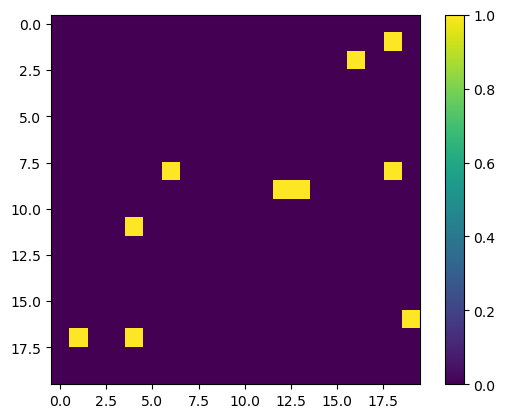

In [65]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for (agents, x, y) in model.grid.coord_iter():
    agent_counts[x][y] = len(agents)
    
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [66]:
# gini for each step in the simulation
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return (1 + (1/N) - (2*B))

In [67]:
class MoneyModel(Model):
    def __init__(self, width, height, num_agents):
        self.num_agents = num_agents
        # non-toroidal grid
        self.grid = MultiGrid(width, height, False)
        
        self.schedule = RandomActivation(self)
        
        self.datacollector =  DataCollector(
            model_reporters = {"Gini" : compute_gini},
            agent_reporters = {"Wealth" : "wealth"}
        )
        
        for i in range(num_agents):
            agent = Person(i, self)
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            self.grid.place_agent(agent, (x,y))
            self.schedule.add(agent)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [68]:
MAX_ITERATIONS = 100
NUM_AGENTS = 10
GRID_SIZE = 20

model = MoneyModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS)

for i in range(MAX_ITERATIONS):
    model.step()

In [69]:
gini = model.datacollector.get_model_vars_dataframe()
agent_wealth = model.datacollector.get_agent_vars_dataframe()

<Axes: >

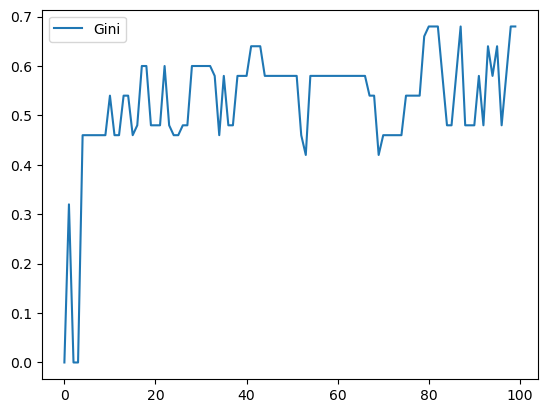

In [70]:
gini.plot()

In [71]:
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<Axes: >

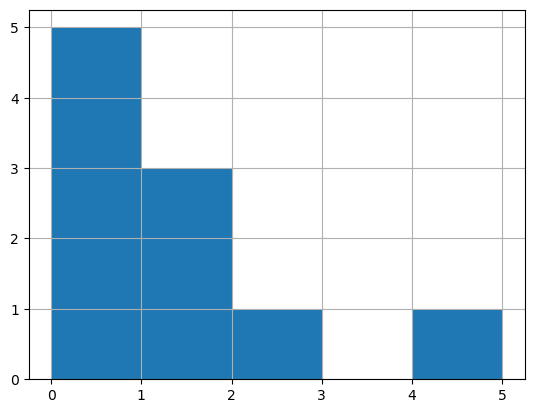

In [72]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

In [79]:
# extract wealth of one agent
one_agent_wealth = agent_wealth.xs(23, level="AgentID")
one_agent_wealth.Wealth.plot()

KeyError: 23

## Batch Run

In [80]:
class MoneyModel(Model):
    def __init__(self, width, height, num_agents):
        self.num_agents = num_agents
        # non-toroidal grid
        self.grid = MultiGrid(width, height, False)
        
        self.schedule = RandomActivation(self)
        
        self.datacollector =  DataCollector(
            model_reporters = {"Gini" : compute_gini},
            agent_reporters = {"Wealth" : "wealth"}
        )
        
        self.running = True
        
        for i in range(num_agents):
            agent = Person(i, self)
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            self.grid.place_agent(agent, (x,y))
            self.schedule.add(agent)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [81]:
from mesa.batchrunner import BatchRunner

In [82]:
# we define 2 dicts, the variable params and fixed params
fixed_params = {"width" : GRID_SIZE, "height" : GRID_SIZE}
# 50 runs
var_params = {"num_agents" : range(10, 500, 10)}

# you can use multiprocessing with batch_runmp

batch_run = BatchRunner(MoneyModel,var_params,fixed_params,
                     iterations=5,max_steps=50,
                     model_reporters={"Gini" : compute_gini}
                       )

C:\Users\Felix\AppData\Local\Temp\ipykernel_17700\2649508117.py:8: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch_run = BatchRunner(MoneyModel,var_params,fixed_params,


In [87]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()

,num_agents,Run,Gini,width,height
0,10,0,0.32,20,20
1,10,1,0.64,20,20
2,10,2,0.32,20,20
3,10,3,0.64,20,20
4,10,4,0.54,20,20


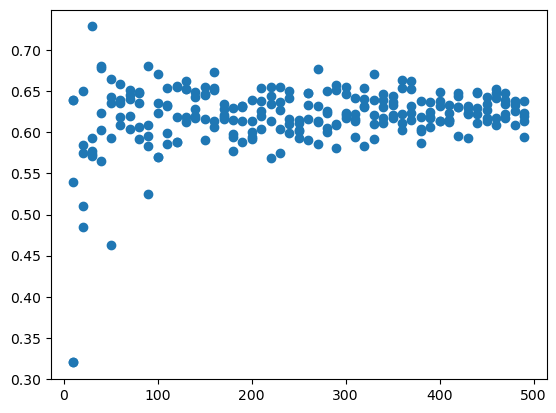

In [88]:
plt.scatter(run_data.num_agents, run_data.Gini)